### 문제 6-1 : 조건부 분기가 있는 메뉴 추천 시스템 ( LangGraph 사용하기)

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

embeddings_model = OllamaEmbeddings(model="bge-m3:latest")

# cafe db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_menu(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

In [4]:
from langchain_community.tools import TavilySearchResults

# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

In [5]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
print(llm.model_name)

# 도구 목록
tools = [search_menu, search_web]
print(type(search_menu))

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
print(type(llm_with_tools))

gpt-4o-mini
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.runnables.base.RunnableBinding'>


In [6]:
system_prompt = dedent("""
당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: search_menu | 아메리카노 | ../data/menu.txt]  
커피 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")


<class 'langgraph.graph.state.CompiledStateGraph'>


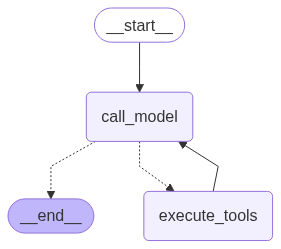

In [7]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
print(type(graph))

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
inputs = {"messages": [HumanMessage(content="커피 메뉴 추천해줘. 해당 커피에 어울리는 디저트도 같이 추천해줘.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

커피 메뉴 추천해줘. 해당 커피에 어울리는 디저트도 같이 추천해줘.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_tSnZ2LaL1MnJ11SSFj1WpSZj)
 Call ID: call_tSnZ2LaL1MnJ11SSFj1WpSZj
  Args:
    query: 커피
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
6. 콜드브루
   • 가격: ₩5,000
   • 주요 원료: 콜드브루 원액, 차가운 물
   • 설명: 찬물에 12-24시간 우려낸 콜드브루 원액을 사용한 시원한 커피입니다. 부드럽고 달콤한 맛이 특징이며, 산미가 적어 누구나 부담 없이 즐길 수 있습니다. 얼음과 함께 시원하게 제공됩니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
3. 카푸치노
   • 가격: ₩5,000
   • 주요 원료: 에스프레소, 스팀 밀크, 우유 거품
   • 설명:

In [18]:
inputs = {"messages": [HumanMessage(content="추천해준 사항의 1번으로 주문하고 싶어. 디저트와 커피 값을 합친 가격은 얼마야?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

추천해준 사항의 1번으로 주문하고 싶어. 디저트와 커피 값을 합친 가격은 얼마야?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_bFMiGdIwako2srLe6JxhQolo)
 Call ID: call_bFMiGdIwako2srLe6JxhQolo
  Args:
    query: 디저트
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    • 설명: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 

In [19]:
inputs = {"messages": [HumanMessage(content="티라미수의 역사에 대해 알려줘.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

티라미수의 역사에 대해 알려줘.
================================== Ai Message ==================================
Tool Calls:
  search_web (call_rwY9toz9aQF9DVLvUJRfsNel)
 Call ID: call_rwY9toz9aQF9DVLvUJRfsNel
  Args:
    query: 티라미수의 역사
================================= Tool Message =================================
Name: search_web

<Document href="https://m.blog.naver.com/tmishaha/221622123079"/>
**티라미수의 기원**

**​**

티라미수의 기원은 1970년대 이탈리아 베네토주(Veneto) 트레비소(Treviso)에서 1939년 처음 문을 연 레스토랑 ‘레 베케리(Le Beccherie)’에서 시작되었다고 한다. 이 식당의 주인인 캄페올(Aldo Campeol)와 이 식당의 페이스트리셰프 링구아노토(Roberto Linguanotto)가 함께 티라미수를 개발했다고 한다. (다른 사람이 개발했다는 이야기도 있고, 이탈리아 전통 티라미수 브랜드 뽐삐에서는 이보다 10년 앞서 이 메뉴를 판매했다고도 함) [...] 기록에 의한 기원은 레 베케리라는 레스토랑에서 처음으로 티라미수가 만들어진 것으로 알려져 있지만, 그 전부터 트레비소의 성매매업소에서 이와 비슷한 디저트를 먹었다는 이야기도 많다. 그곳에서 일하던 사람들이 지친 몸을 달래고자 지역 식재료로 만들어 먹던 이 디저트는 성매매업소 손님들에게 정력제로 입소문이 나면서 많은 인기를 누렸다고 한다. 1958년 이탈리아 정부의 성매매 근절 정책으로 성매매업소가 사라지면서 정력제 